In [1]:
!pip install requests

Import Directly to Colab

In [4]:
import requests
import zipfile
from io import BytesIO

# URL of the zip file you want to download
zip_file_url = 'https://storage.googleapis.com/kaggle-competitions-data/kaggle-v2/7880/862031/bundle/archive.zip?GoogleAccessId=web-data@kaggle-161607.iam.gserviceaccount.com&Expires=1700705285&Signature=BRIcmXp%2FXLuoXZUhwsoI38Z6qZ06tYWMj7GjGfi3867yf9DRA4wRL5p1hhGuQI%2BuDRT43%2BkDjpK6%2BSQvJ6OZTmTp%2BcY%2BETUmQAGVlcek2%2B5x231vqmYGWZTKFEKKyUfXGYm7BYMtXOtjAuAsPng9z%2FPIgWVUgv7d5OD2sjp%2Bwwq%2BsVI2Qjy9c97TCVuFdPxcElLV%2FO%2FLF4JrC%2Bm%2BJ12zYTN%2Bntq7gFvfT9nasiTKSylSb4UeQu4waeHUhFDVJuX%2FPul1On8P5fhxXEM5PLAfdOJMpK8UdszFKkJK5vb3QEID53HpQWLyhLKgrXVHSK5WVQE8ZO3KFbobvOYHzKV1ug%3D%3D&response-content-disposition=attachment%3B+filename%3Dplant-seedlings-classification.zip'
# Send an HTTP GET request to the URL
response = requests.get(zip_file_url)

if response.status_code == 200:
    # If the request is successful, extract the contents of the zip file
    with zipfile.ZipFile(BytesIO(response.content), 'r') as zip_ref:
        zip_ref.extractall('/content/plantseedling')  # Extract to the /content directory in Colab
    print("Zip file extracted successfully.")
else:
    print(f"Failed to download the zip file. Status code: {response.status_code}")

Zip file extracted successfully.


Import Necessary Libraries

In [5]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils import compute_class_weight
import seaborn as sns
from glob import glob   #
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from keras.applications.resnet50 import preprocess_input as resnet_preprocess
from tensorflow.keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_v3 import preprocess_input as inception_preprocess  #
from tensorflow.keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input as vgg16_preprocess
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.optimizers import Adam

Train and Test Data

In [6]:
path_training = '/content/plantseedling/train'
images_train = glob(f'{path_training}/*/*.png')
train_images = pd.DataFrame({'Images':images_train})
train_images['label'] = train_images['Images'].apply(lambda x: x.split('/')[-2])


path_testing = '/content/plantseedling/test'
images_test = glob(f'{path_testing}/*.png')
test_images = pd.DataFrame({'Images':images_test})

In [7]:
Labels=list(np.unique(train_images['label']))
print(Labels)

['Black-grass', 'Charlock', 'Cleavers', 'Common Chickweed', 'Common wheat', 'Fat Hen', 'Loose Silky-bent', 'Maize', 'Scentless Mayweed', 'Shepherds Purse', 'Small-flowered Cranesbill', 'Sugar beet']


In [8]:
train_images['label'].value_counts()

Loose Silky-bent             654
Common Chickweed             611
Scentless Mayweed            516
Small-flowered Cranesbill    496
Fat Hen                      475
Charlock                     390
Sugar beet                   385
Cleavers                     287
Black-grass                  263
Shepherds Purse              231
Maize                        221
Common wheat                 221
Name: label, dtype: int64

In [9]:
train_data, val_data = train_test_split(train_images, stratify = train_images['label'], test_size=0.2)

Data Augmentation

In [10]:
train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=20,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   horizontal_flip=True)


val_datagen = ImageDataGenerator(rescale=1./255)

In [11]:
train_data_aug = train_datagen.flow_from_dataframe(train_data,
                                               x_col='Images',
                                               y_col='label',
                                               target_size=(224, 224),
                                               batch_size=32,
                                               class_mode='categorical')


val_data_aug = val_datagen.flow_from_dataframe(val_data,
                                           x_col='Images',
                                           y_col='label',
                                           target_size=(224, 224),
                                           batch_size=32,
                                           class_mode='categorical')

Found 3800 validated image filenames belonging to 12 classes.
Found 950 validated image filenames belonging to 12 classes.


 Count the number of samples in each class

In [12]:


unique, counts = np.unique(train_data_aug.classes, return_counts=True)
label_count = dict(zip(unique, counts))

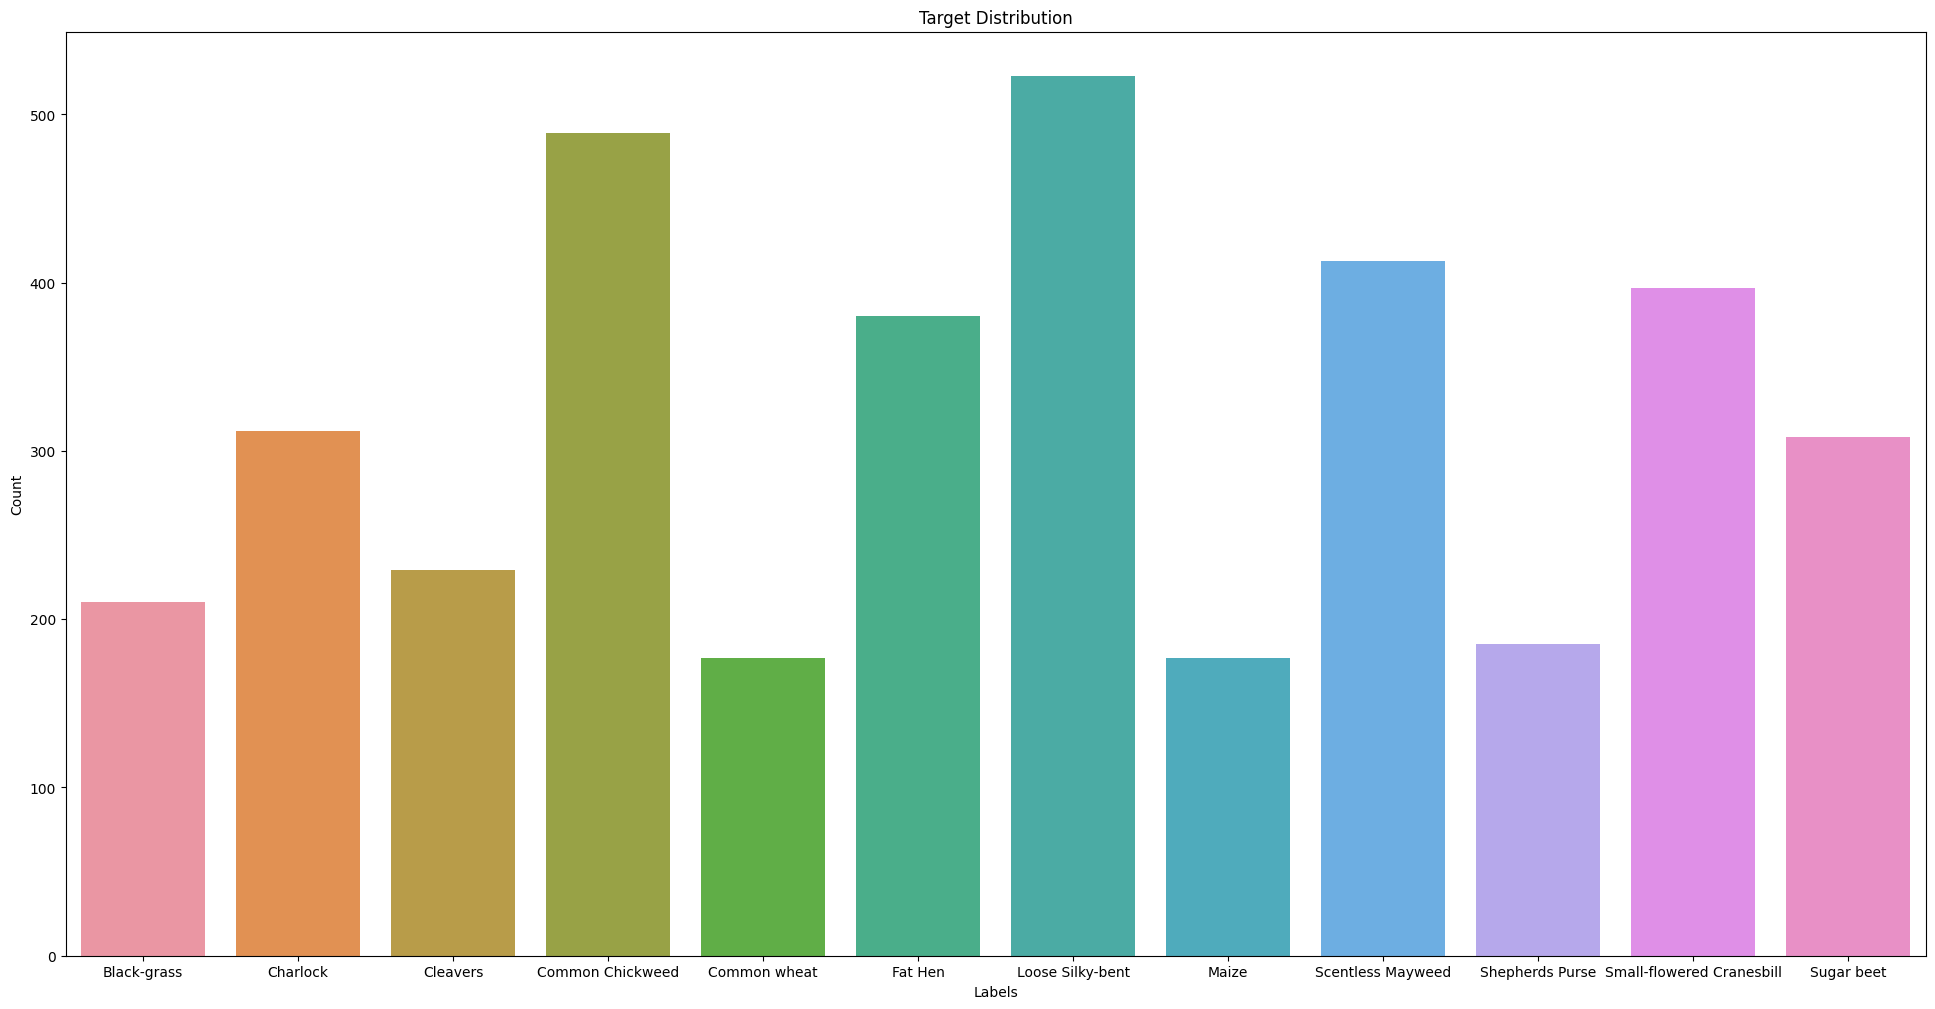

In [14]:
plt.figure(figsize=(24, 12))
sns.barplot(x=Labels, y=list(label_count.values()))
plt.xlabel("Labels")
plt.ylabel("Count")
plt.title("Target Distribution")
plt.show()

In [15]:
num_classes = train_data['label'].nunique()

In [31]:
epochs_num = 5

Plot Function

In [17]:


def plotts(history, model_name):
    history_df = pd.DataFrame(history.history)
    fig, ax = plt.subplots(figsize=(16,9), nrows=1,ncols=2)
    history_df[['loss','val_loss']].plot(ax=ax[0], xlabel='Epoch',ylabel='Loss', title=f'{model_name} || Loss vs Epoch')
    history_df[['accuracy','val_accuracy']].plot(ax=ax[1], xlabel='Epoch',ylabel='Accuracy',title=f'{model_name} || Accuracy vs Epoch')
    plt.legend()
    plt.show()

Confusion Matrrix Function

In [18]:


def ConfusionMatrix(y_pred, y_true, model_name):
  cnf_matrix = confusion_matrix(y_pred, y_true)
  fig = plt.figure(figsize=(12,12))
  sns.heatmap(cnf_matrix, annot=True, xticklabels=Labels, yticklabels=Labels)
  plt.title(f'{model_name} || Confusion Matrix')
  plt.ylabel('True Labels')
  plt.xlabel('Predicted Labels')
  plt.show();

Classification Report Function

In [19]:


def ClassificationReport(y_pred, y_true, model_name):
  print(f"{model_name} || Classification Report")
  print(classification_report(y_true, y_pred))

For comparing models

In [20]:


def comparison(history, model_name):
    history_df = pd.DataFrame(history.history)
    print(f'{model_name}')
    print(history_df.tail(1))

# Inception

In [21]:


inception_base = InceptionV3(weights='imagenet',
                             include_top=False,
                             input_shape=(224,224,3))

inception_base.trainable = False

87910968/87910968 [==============================] - 0s 0us/step


Applying Data Augmentation

In [22]:


inception_train_gen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=20,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   horizontal_flip=True,
                                   preprocessing_function=inception_preprocess)

In [24]:


inception_model = Sequential([
    inception_base,
    Flatten(),
    Dense(512, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    BatchNormalization(),
    Dense(num_classes, activation='softmax')
])

Training

In [32]:


optimizer = Adam(learning_rate = 0.001)
inception_model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'], )
optimizer.build(inception_model.trainable_variables)

history_inception = inception_model.fit(train_data_aug, validation_data=val_data_aug, epochs=epochs_num, batch_size=64)


Epoch 1/5
119/119 [==============================] - 793s 7s/step - loss: 1.3518 - accuracy: 0.5505 - val_loss: 1.0102 - val_accuracy: 0.6684
Epoch 2/5
119/119 [==============================] - 793s 7s/step - loss: 0.9483 - accuracy: 0.6768 - val_loss: 0.8181 - val_accuracy: 0.7179
Epoch 3/5
119/119 [==============================] - 783s 7s/step - loss: 0.8411 - accuracy: 0.7050 - val_loss: 2.3816 - val_accuracy: 0.4411
Epoch 4/5
119/119 [==============================] - 786s 7s/step - loss: 0.7835 - accuracy: 0.7374 - val_loss: 0.6123 - val_accuracy: 0.8021
Epoch 5/5
119/119 [==============================] - 784s 7s/step - loss: 0.7297 - accuracy: 0.7529 - val_loss: 0.5745 - val_accuracy: 0.8000


Graphs


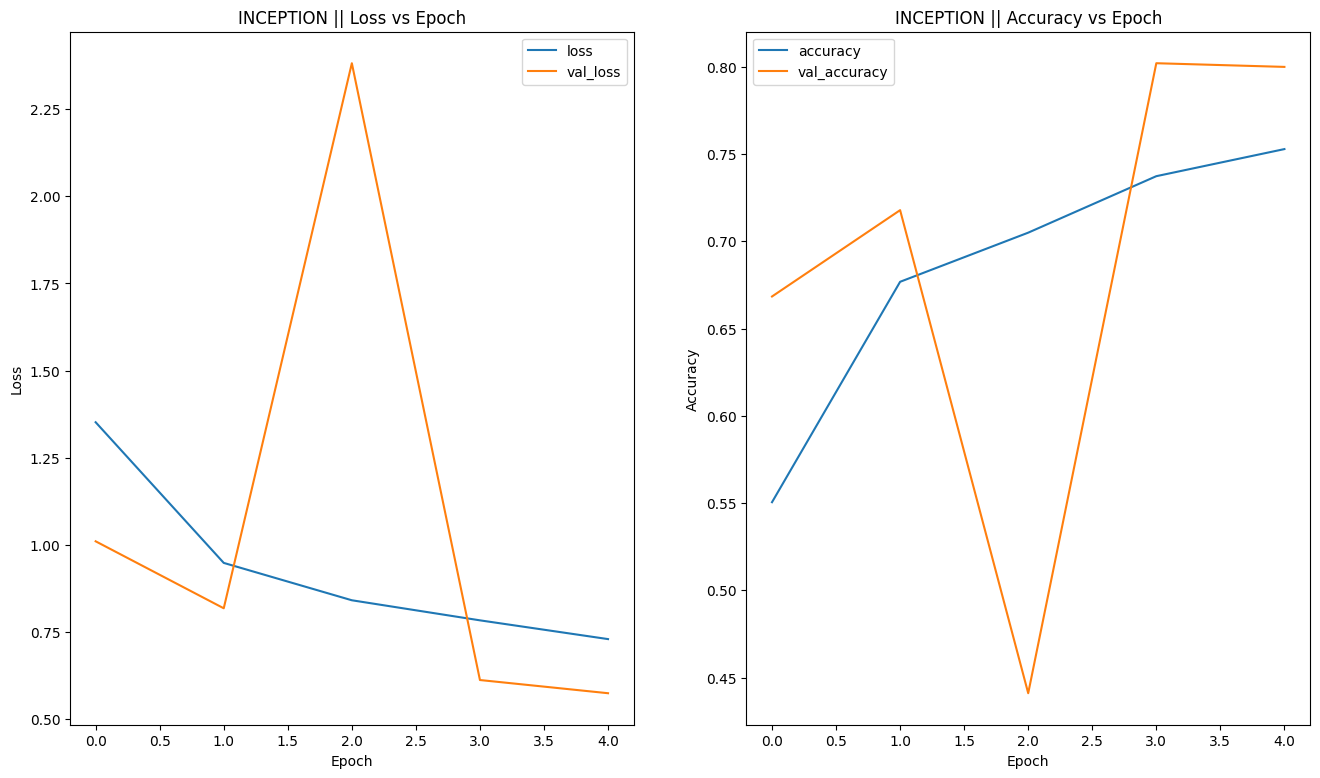

In [33]:

plotts(history_inception, model_name="INCEPTION")

Save and Load

In [34]:


inception_model.save('inception.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [35]:


inception_loaded = load_model('inception.h5')

Making Predictions

In [36]:


predictions_inception = np.argmax(inception_loaded.predict(val_data_aug), axis=1)
y_true_inception = val_data['label'].map(val_data_aug.class_indices)

30/30 [==============================] - 168s 5s/step


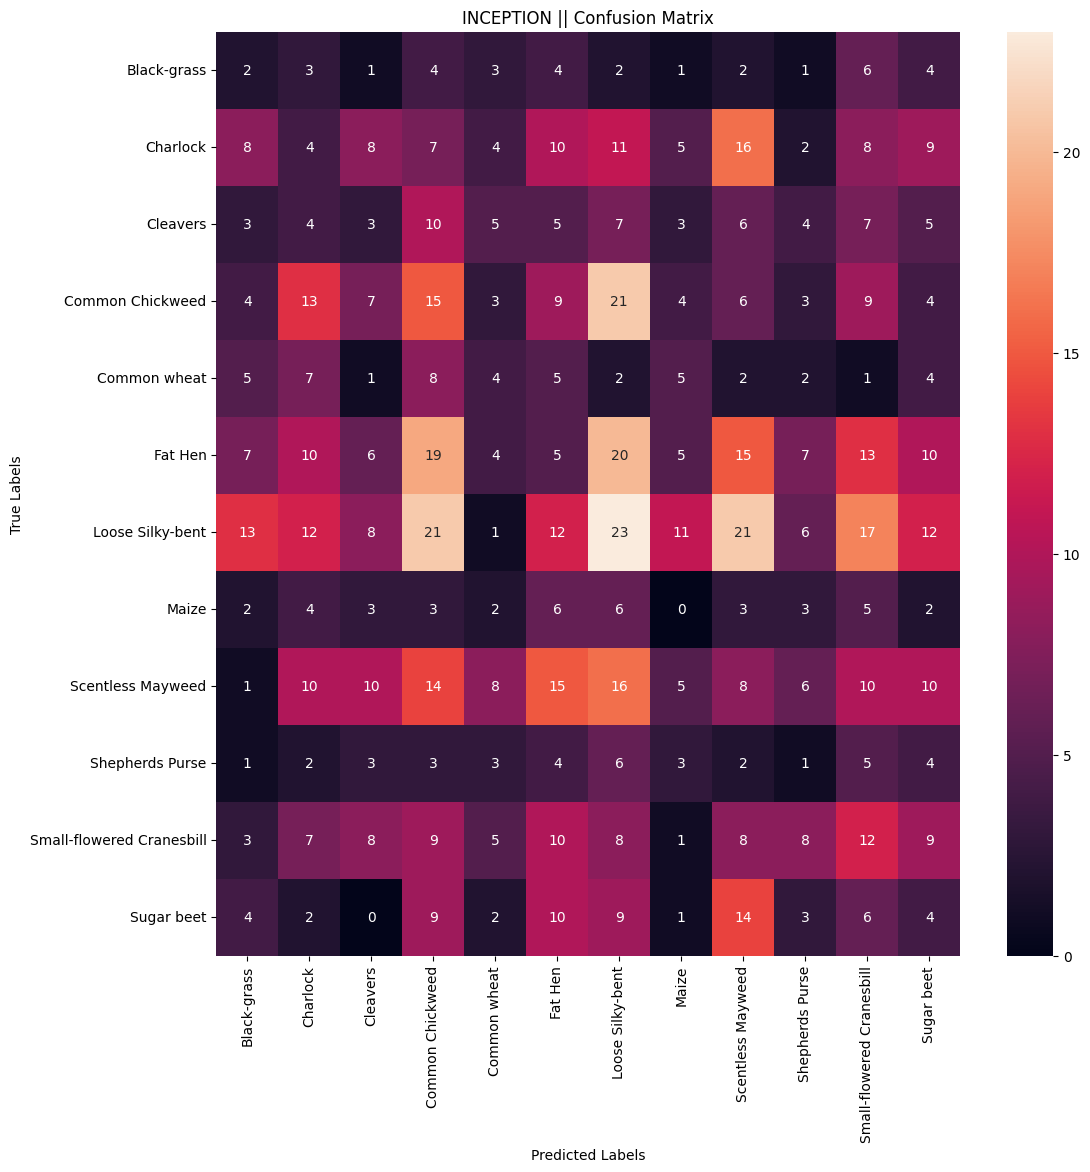

In [37]:


ConfusionMatrix(y_pred = predictions_inception, y_true = y_true_inception, model_name="INCEPTION")

In [40]:


ClassificationReport(predictions_inception, y_true = y_true_inception, model_name="INCEPTION")

INCEPTION || Classification Report
              precision    recall  f1-score   support

           0       0.06      0.04      0.05        53
           1       0.04      0.05      0.05        78
           2       0.05      0.05      0.05        58
           3       0.15      0.12      0.14       122
           4       0.09      0.09      0.09        44
           5       0.04      0.05      0.05        95
           6       0.15      0.18      0.16       131
           7       0.00      0.00      0.00        44
           8       0.07      0.08      0.07       103
           9       0.03      0.02      0.02        46
          10       0.14      0.12      0.13        99
          11       0.06      0.05      0.06        77

    accuracy                           0.09       950
   macro avg       0.07      0.07      0.07       950
weighted avg       0.09      0.09      0.08       950



# ResNet


In [41]:


resnet_base = ResNet50(weights='imagenet',
                       include_top=False,
                       input_shape=(224,224,3))

resnet_base.trainable = False

94765736/94765736 [==============================] - 0s 0us/step


Data Augmentation and Preprocessing

In [42]:


resnet_train_gen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=20,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   horizontal_flip=True,
                                   preprocessing_function=resnet_preprocess)

Model Building and Training

In [43]:


resnet_model = Sequential([
    resnet_base,
    Flatten(),
    Dense(512, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    BatchNormalization(),
    Dense(num_classes, activation='softmax')
])

In [44]:


opt = Adam(learning_rate=0.001)

resnet_model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

history_resnet = resnet_model.fit(train_data_aug, validation_data=(val_data_aug), epochs=epochs_num, batch_size=64)

Epoch 1/5
119/119 [==============================] - 1241s 10s/step - loss: 2.4740 - accuracy: 0.1711 - val_loss: 8.8472 - val_accuracy: 0.1705
Epoch 2/5
119/119 [==============================] - 1302s 11s/step - loss: 2.3663 - accuracy: 0.1879 - val_loss: 15.6753 - val_accuracy: 0.1695
Epoch 3/5
119/119 [==============================] - 1225s 10s/step - loss: 2.3440 - accuracy: 0.1945 - val_loss: 16.8289 - val_accuracy: 0.1084
Epoch 4/5
119/119 [==============================] - 1279s 11s/step - loss: 2.2882 - accuracy: 0.2145 - val_loss: 7.4376 - val_accuracy: 0.0632
Epoch 5/5
119/119 [==============================] - 1224s 10s/step - loss: 2.2576 - accuracy: 0.2158 - val_loss: 9.6753 - val_accuracy: 0.1379


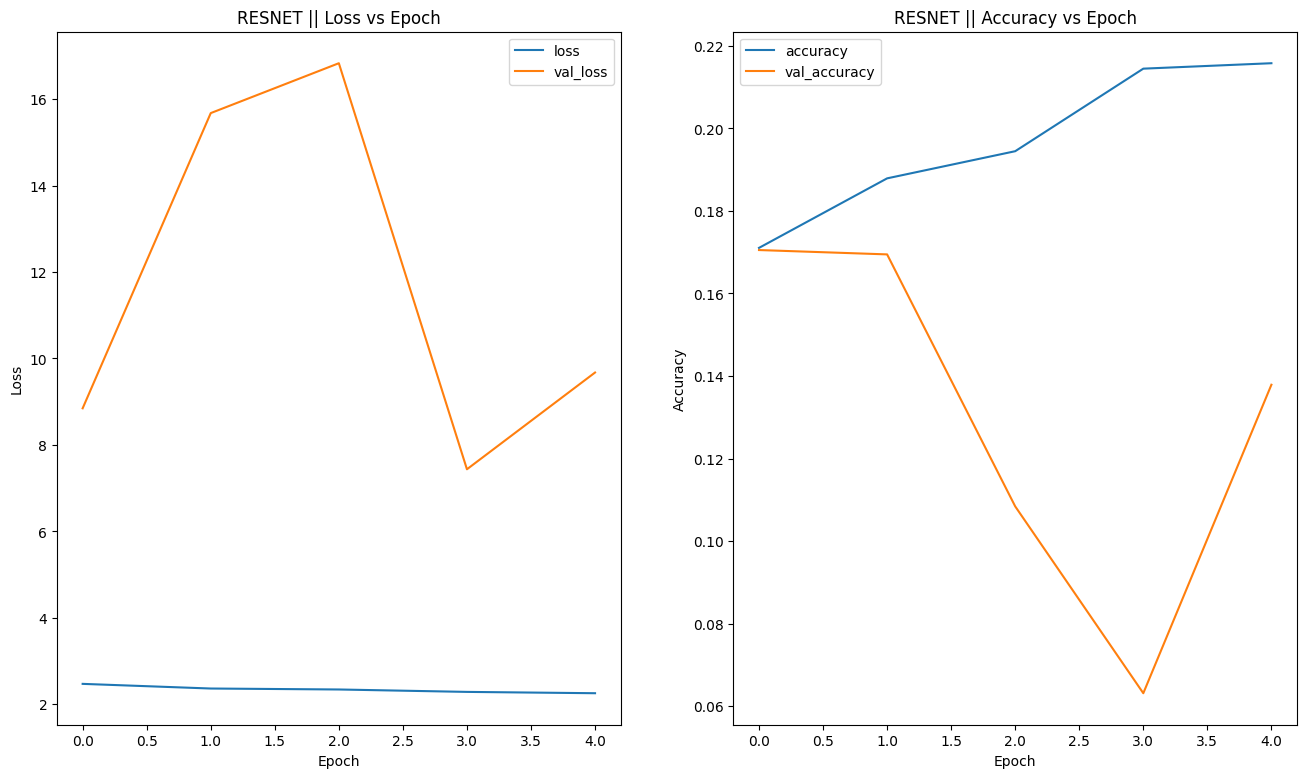

In [45]:


plotts(history_resnet, model_name="RESNET")

Save and Load

In [46]:
resnet_model.save('resnet.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [47]:
resnet_loaded = load_model('resnet.h5')

Making Predictions

In [48]:

predictions_resnet = np.argmax(resnet_loaded.predict(val_data_aug), axis=1)
y_true_resnet = val_data['label'].map(val_data_aug.class_indices)

30/30 [==============================] - 213s 7s/step


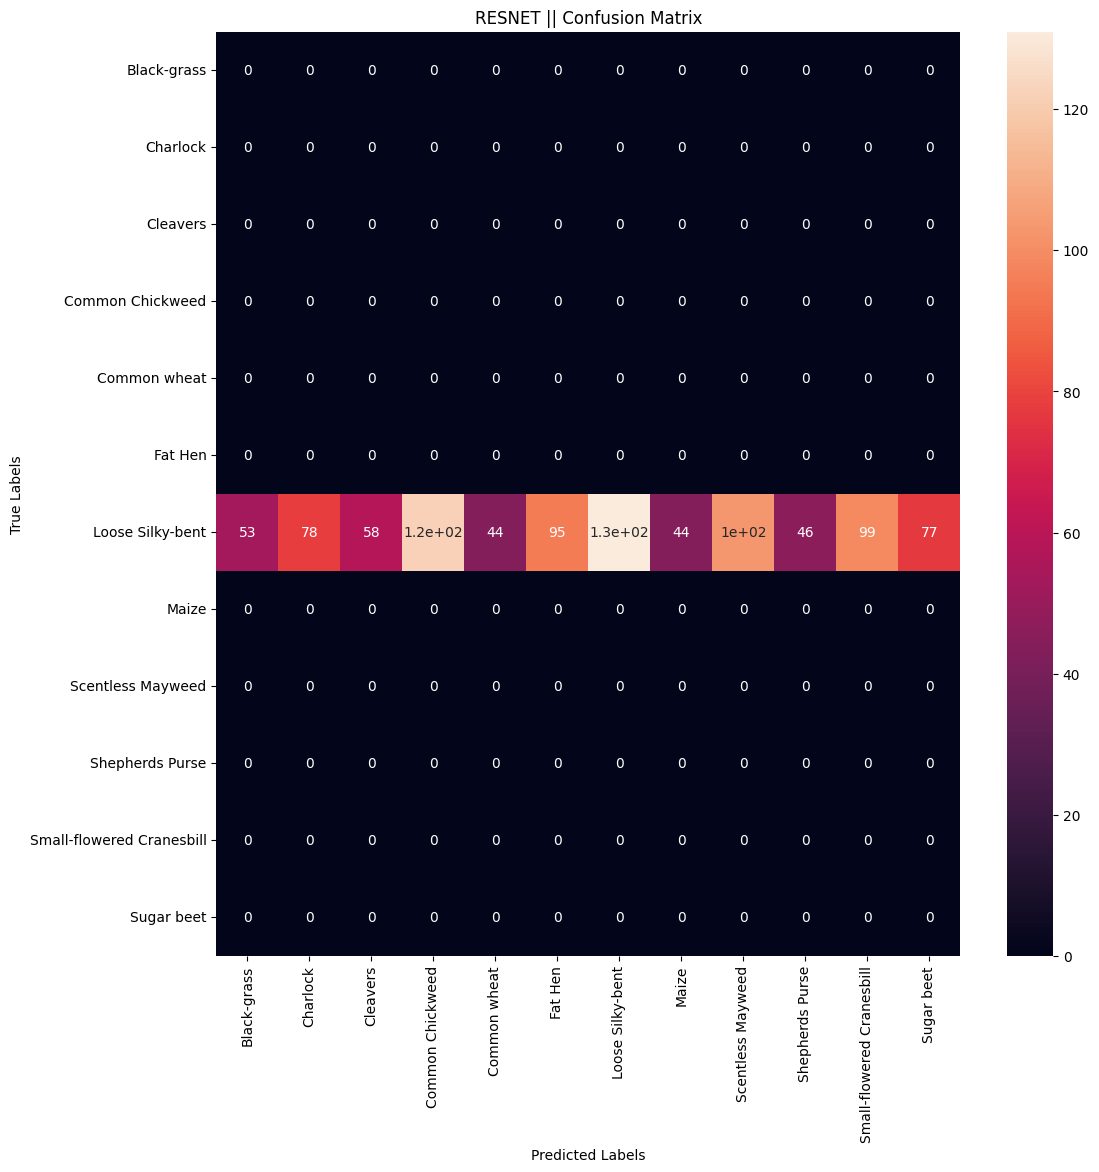

In [49]:
# Confusion Matrix
ConfusionMatrix(y_pred = predictions_resnet, y_true = y_true_resnet, model_name="RESNET")

In [50]:
# Classification Report
ClassificationReport(predictions_resnet, y_true = y_true_resnet, model_name="RESNET")

RESNET || Classification Report
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        53
           1       0.00      0.00      0.00        78
           2       0.00      0.00      0.00        58
           3       0.00      0.00      0.00       122
           4       0.00      0.00      0.00        44
           5       0.00      0.00      0.00        95
           6       0.14      1.00      0.24       131
           7       0.00      0.00      0.00        44
           8       0.00      0.00      0.00       103
           9       0.00      0.00      0.00        46
          10       0.00      0.00      0.00        99
          11       0.00      0.00      0.00        77

    accuracy                           0.14       950
   macro avg       0.01      0.08      0.02       950
weighted avg       0.02      0.14      0.03       950



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# VGG16

In [51]:
vgg_base = VGG16(weights='imagenet',
                 include_top=False,
                 input_shape=(224,224,3))

vgg_base.trainable = False

58889256/58889256 [==============================] - 0s 0us/step


In [52]:
vgg_train_gen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=20,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   horizontal_flip=True,
                                   preprocessing_function=vgg16_preprocess)

Model Build and Train

In [53]:

vgg_model = Sequential([
    vgg_base,
    Flatten(),
    Dense(512, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    BatchNormalization(),
    Dense(num_classes, activation='softmax')
])

In [54]:
opt = Adam(learning_rate = 0.001)

vgg_model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

history_vgg = vgg_model.fit(train_data_aug, validation_data=val_data_aug, epochs=epochs_num, batch_size=64)

Epoch 1/5
119/119 [==============================] - 3312s 28s/step - loss: 1.9520 - accuracy: 0.3584 - val_loss: 2.8329 - val_accuracy: 0.2516
Epoch 2/5
119/119 [==============================] - 3248s 27s/step - loss: 1.4834 - accuracy: 0.5037 - val_loss: 1.7266 - val_accuracy: 0.4263
Epoch 3/5
119/119 [==============================] - 3252s 27s/step - loss: 1.3487 - accuracy: 0.5345 - val_loss: 1.3131 - val_accuracy: 0.5337
Epoch 4/5
119/119 [==============================] - 3243s 27s/step - loss: 1.2390 - accuracy: 0.5795 - val_loss: 1.0599 - val_accuracy: 0.6347
Epoch 5/5
119/119 [==============================] - 3147s 26s/step - loss: 1.1934 - accuracy: 0.5900 - val_loss: 1.2720 - val_accuracy: 0.5442


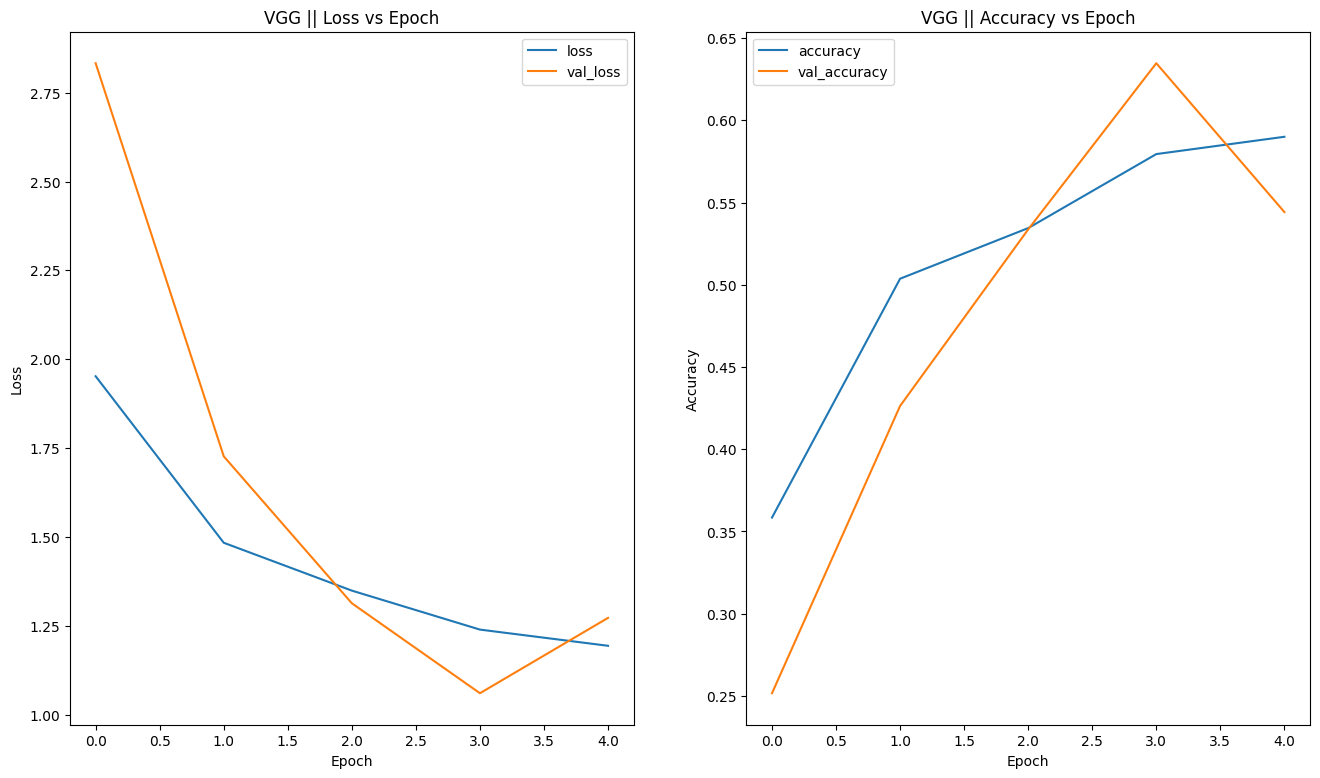

In [55]:
plotts(history_vgg, model_name="VGG")

In [56]:
vgg_model.save('vgg.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [57]:
vgg_loaded = load_model('vgg.h5')

In [58]:
predictions_vgg = np.argmax(vgg_loaded.predict(val_data_aug), axis=1)
y_true_vgg = val_data['label'].map(val_data_aug.class_indices)

30/30 [==============================] - 610s 20s/step


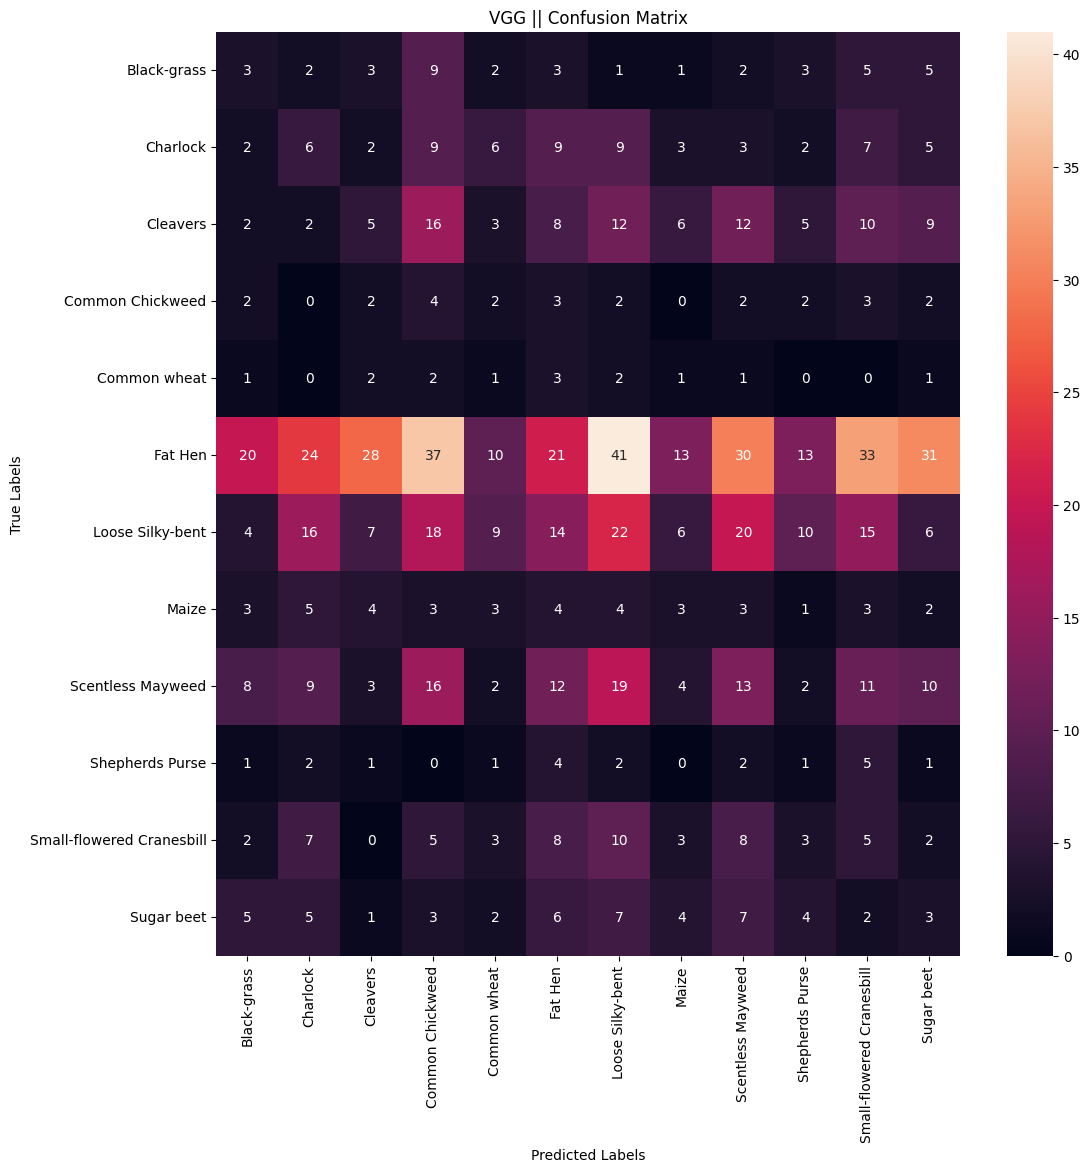

In [64]:
ConfusionMatrix(y_pred = predictions_vgg, y_true = y_true_vgg, model_name="VGG")

In [65]:
ClassificationReport(y_pred = predictions_vgg, y_true = y_true_vgg, model_name="VGG")

VGG || Classification Report
              precision    recall  f1-score   support

           0       0.08      0.06      0.07        53
           1       0.10      0.08      0.09        78
           2       0.06      0.09      0.07        58
           3       0.17      0.03      0.05       122
           4       0.07      0.02      0.03        44
           5       0.07      0.22      0.11        95
           6       0.15      0.17      0.16       131
           7       0.08      0.07      0.07        44
           8       0.12      0.13      0.12       103
           9       0.05      0.02      0.03        46
          10       0.09      0.05      0.06        99
          11       0.06      0.04      0.05        77

    accuracy                           0.09       950
   macro avg       0.09      0.08      0.08       950
weighted avg       0.10      0.09      0.08       950



In [63]:
comparison(history_inception, model_name="INCEPTION")
comparison(history_resnet, model_name="RESNET")
comparison(history_vgg, model_name="VGG")

INCEPTION
       loss  accuracy  val_loss  val_accuracy
4  0.729715  0.752895  0.574468           0.8
RESNET
       loss  accuracy  val_loss  val_accuracy
4  2.257587  0.215789  9.675251      0.137895
VGG
       loss  accuracy  val_loss  val_accuracy
4  1.193413      0.59     1.272      0.544211
